Import necessary libraries and hyperparameters

In [5]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

batch_size = 16
block_size = 32
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
drop_out = 0.0
torch.manual_seed(42)

In [7]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print('Length of text:', len(text))
print('First 300 characters of the text:', text[:300])
chars = sorted(list(set(text)))
vocab_size = len(chars)
print('Character appeared in the text', ''.join(chars))
print('Number of characters:', vocab_size)

stoi = { ch:i for i, ch in enumerate(chars) }
itos = { i:ch for i, ch in enumerate(chars) }

encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])
print('Encoding Results: ', encode('Hello World!'))
print('Decoding Results: ', decode(encode('Hello World!')))

Length of text: 1115394
First 300 characters of the text: First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us
Character appeared in the text 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
Number of characters: 65
Encoding Results:  [20, 43, 50, 50, 53, 1, 35, 53, 56, 50, 42, 2]
Decoding Results:  Hello World!


Dataset Separation and Batch Split

In [8]:
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

Model Evaluation

In [ ]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [10]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)

        # 创建一个下三角矩阵，并将其注册为模型的一个缓冲区
        # 用于计算masked self-attention时作为mask
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(drop_out)
    def forward(self, x):
        # batch size, block size, embedding size
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)

        wei = q @ k.transpose(-2, -1) * C ** (-0.5)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        out = wei @ v
        return out

In [13]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(drop_out)
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4*n_embd),
            nn.ReLU(),
            nn.Linear(4*n_embd, n_embd),
            nn.Dropout(drop_out),
        )
    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x



In [14]:
class BigramLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)

        self.blocks = nn.Sequential(*[Block(n_embd, n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

0.209729 M parameters
step 0: train loss 4.44, val loss 4.44
step 100: train loss 2.68, val loss 2.69
step 200: train loss 2.50, val loss 2.50
step 300: train loss 2.42, val loss 2.42
step 400: train loss 2.35, val loss 2.35
step 500: train loss 2.30, val loss 2.31
step 600: train loss 2.25, val loss 2.27
step 700: train loss 2.20, val loss 2.21
step 800: train loss 2.16, val loss 2.19
step 900: train loss 2.12, val loss 2.15
step 1000: train loss 2.11, val loss 2.15
step 1100: train loss 2.06, val loss 2.10
step 1200: train loss 2.03, val loss 2.08
step 1300: train loss 2.01, val loss 2.05
step 1400: train loss 1.99, val loss 2.05
step 1500: train loss 1.96, val loss 2.03
step 1600: train loss 1.95, val loss 2.01
step 1700: train loss 1.93, val loss 1.99
step 1800: train loss 1.90, val loss 1.98
step 1900: train loss 1.88, val loss 1.96
step 2000: train loss 1.86, val loss 1.96
step 2100: train loss 1.85, val loss 1.96
step 2200: train loss 1.84, val loss 1.94
step 2300: train loss 1.

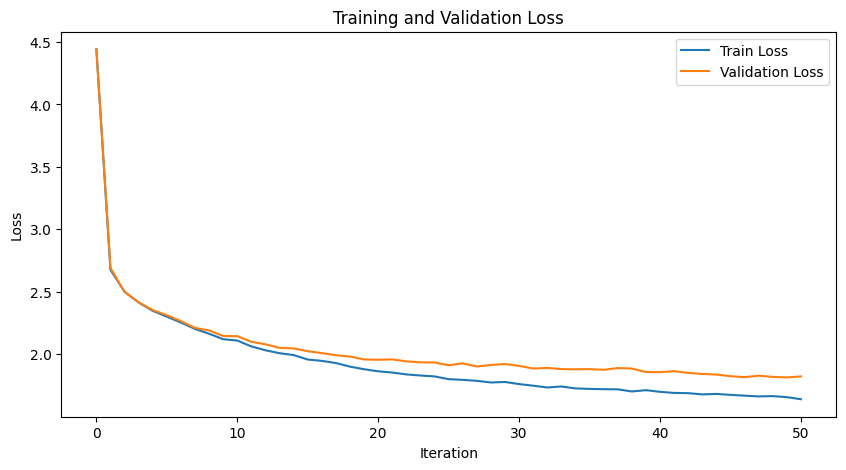

In [15]:
model = BigramLanguageModel().to(device)

print(sum(p.numel() for p in model.parameters()) / 1e6, 'M parameters')

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.2f}, val loss {losses['val']:.2f}")
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('loss.png') 
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=200)[0].tolist()))

In [16]:
print(decode(model.generate(context, max_new_tokens=1000)[0].tolist()))


As ingrar my from steepets: thou tha's my friend I have agriven!-
IShoh heer must ack'd brother
Where God that was ready, what peacue thy gosonger:
Alus I will god Hockin theing, tender of all then unwer annower
But Remeo, sir my ascure on my fories,
If so take unhis the advanse,
The worthung not havess froguis Riy.
be I thy lumb:' and as syet, you tride,
Some stoods,
Speak are.

RUCENEES:
Mever,
He tild Murse wash body and king,
Sir.

NRY MARTHASBYORD:
Aluor here make!
Where it, and'stating trush!

FORD BOLINGBROHAND:
My comforthy shalrister your paster'd boanness forthen they
If I'll speak her.

POMD:
So conder frier, eremilion.

Nurse: March that
Counser call be your harrs, what a thy threavese,
You than thank that you chary again's thanful's not thy quoner oar,
Or quearn, no, sir.

TEMINIUS:
And are what jewer, then
Making my stubjectip,
To cupce! Vold Morrow hidurse,
Bettendamver thy fir a laKy his tombe:
And night, ax see,'
And his beand, he, she's this out liest books poishaly,

In [21]:
print(f"Actual memory used: {torch.cuda.memory_allocated() / 1024 ** 2} MB")
print(f"Reserved memory: {torch.cuda.memory_reserved() / 1024 ** 2} MB")

Actual memory used: 19.6767578125 MB
Reserved memory: 34.0 MB
